# U-Net Segmentation

A more sophisticated approach is needed to segment the wires from the images. Multiple ones are available but the first one used is the U-Net. 



In [1]:
# import modules (download with pip install first if not on local. Type on terminal: pip install <module name>)
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use
import numpy as np

# install torchvision first
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print("Using",device,"...")

Using cuda:0 ...


## Dataset

In [2]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
# X, y = load_data('.', 'small_dataset')
X, y = load_data('.', 'iteration_1_dataset')

In [3]:
from tqdm import tqdm

# implement Simulation of Dataset 
class SimDataset(Dataset):
    def __init__(self, count,mode,transform=None):

        if mode == '_train': 
            _simulated = X[0:int(count*X.shape[0])]
            _ground_truth = y[0:int(count*y.shape[0])]
        elif mode == '_val': 
            _simulated = X[-(int(count*X.shape[0])):]
            _ground_truth = y[-(int(count*y.shape[0])):]

        self.input_images, self.target_masks = np.array(_simulated), np.array(_ground_truth)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
            
        return [image, mask]

# Tranform into pytorch tensors 
trans = transforms.Compose([
    transforms.ToTensor(),
])

# Create a train set and a validation set, each with input images (simulation data) and target masks (ground truth data)
train_set = SimDataset(0.8,'_train',transform = trans)
val_set = SimDataset(0.2,'_val',transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 50

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

print(dataset_sizes)

{'train': 1600, 'val': 400}


In [173]:
from scipy.ndimage import gaussian_filter

def norm(im):
    im -= im.min()
    im = im / im.max()
    return im

def modify_gts(gts):
    gts_smoothed = [(norm(gaussian_filter(gt, sigma = 0.4)) > 0.01).astype(np.int) for gt in gts]
#     gts = [(1 - gaussian_filter(gt, sigma = 5)) ** (-0.03) for gt in gts]
#     for i in range(len(gts_smoothed)):
#         gt = gts_smoothed[i]
# #         gt[gt > 0] = (1 - gt[gt > 0]) ** (-3)
#         gts_smoothed[i] = gt - np.min(gt)
#         gts_smoothed[i] = gt / np.max(gt)
    return gts_smoothed

(128, 64)


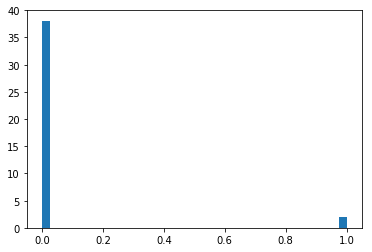

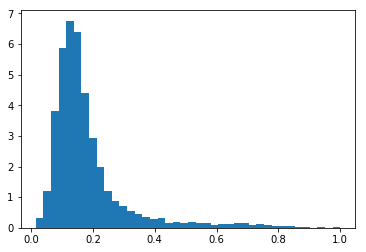

Class balance (one sigma):  4.8095703125 %
Loss for null model: 0.04578253626823425


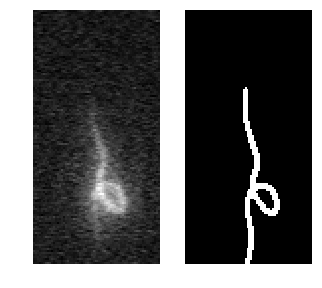

Class balance (one sigma):  5.06591796875 %
Loss for null model: 0.04809287562966347


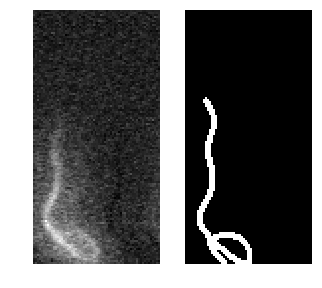

Class balance (one sigma):  6.25 %
Loss for null model: 0.05859375


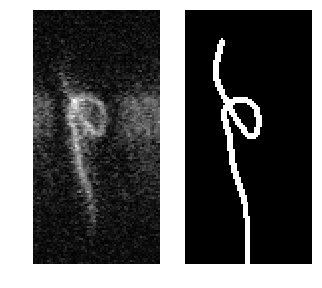

In [174]:
import matplotlib.pyplot as plt

loss_function = nn.MSELoss()

def show(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')

print(dataloaders['train'])
n = 3
first_batch = next(iter(dataloaders['train']))

ims = first_batch[0][:n]
gts_thin = first_batch[1][:n]
gts = modify_gts(gts_thin)
# gts = first_batch[1][:n].numpy()

print(gts[0].shape)
h2 = plt.hist(gts[0].reshape(-1,1), bins = 40, density = True, alpha=1)
plt.show()
h2 = plt.hist(ims[0].numpy().reshape(-1,1), bins = 40, density = True, alpha=1)
plt.show()

for [im], gt in zip(ims, gts):
    plt.figure(figsize=[5]*2)
    plt.subplot(121)
    show(im)

    plt.subplot(122)
    show(gt)

    base_loss = loss_function(torch.Tensor(np.ones(gt.shape) * np.average(gt)), torch.Tensor(gt))
    print('Class balance (one sigma): ', 100 * np.sum((gt - np.std(gt)) > 0) / np.prod(gt.shape), '%')
    print('Loss for null model:', base_loss.item())
    
    plt.show()

## Model

In [175]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
print(inputs.dtype, masks.dtype)

for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

# install torchsummary first
from torchsummary import summary
# import model from python file
import Unet_pytorch
import importlib
importlib.reload(Unet_pytorch)

model = Unet_pytorch.UNet(1)
model = model.to(device)

print("MODEL ARCHITECTURE ...")
summary(model, input_size=(1,128,64))

save_path = './saved_models/model_1'

torch.Size([50, 1, 128, 64]) torch.Size([50, 128, 64])
torch.float64 torch.float64
0.00023383342021162485 1.0 0.1988745253842463 0.14026251032184392
0.0 1.0 0.020849609375 0.14288073055492792
MODEL ARCHITECTURE ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 64]             320
       BatchNorm2d-2          [-1, 32, 128, 64]              64
              ReLU-3          [-1, 32, 128, 64]               0
            Conv2d-4          [-1, 32, 128, 64]           9,248
       BatchNorm2d-5          [-1, 32, 128, 64]              64
              ReLU-6          [-1, 32, 128, 64]               0
         MaxPool2d-7           [-1, 32, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          18,496
       BatchNorm2d-9           [-1, 64, 64, 32]             128
             ReLU-10           [-1, 64, 64, 32]               0
           Conv2

## Training

In [176]:
from torch.utils.tensorboard import SummaryWriter
import datetime
writer = SummaryWriter('./logs/{0}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
def visualise(outputs, title, n=7):
    fig = plt.figure(figsize=[10, 3])
    fig.suptitle(title, fontsize=14)
    for i, output in enumerate(outputs[:n]):
        plt.subplot(1,n,i+1)
        plt.axis('off')
        plt.imshow(output) if output.shape[0] == 3 else plt.imshow(output, cmap='gray')
    plt.show()

Epoch 0/99
----------
LR 0.01
Batch 0 : 0.2362813502550125
Batch 10 : 0.13951654732227325
Batch 20 : 0.07482102513313293
Batch 30 : 0.05103291571140289
Loss train : 0.11651383
Batch 0 : 0.05903104692697525
Loss val : 0.05993142


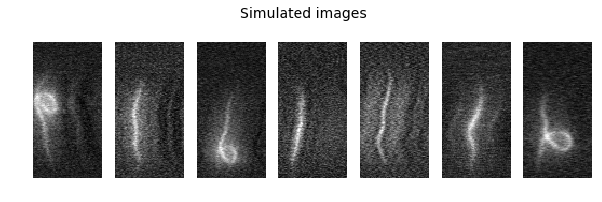

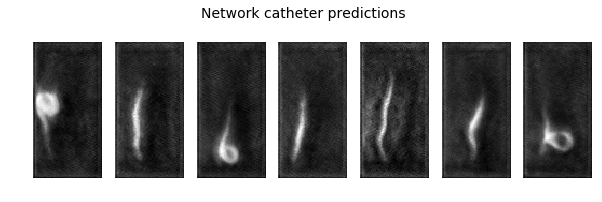

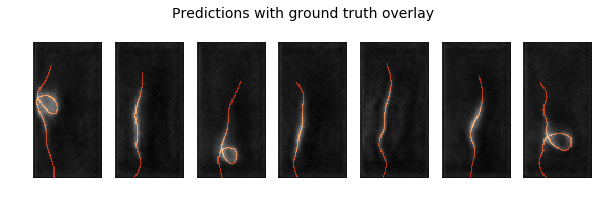

saving best model
0m 6s
Epoch 1/99
----------
LR 0.01
Batch 0 : 0.047904785722494125
Batch 10 : 0.03945317491889
Batch 20 : 0.03570758178830147
Batch 30 : 0.030463168397545815
Loss train : 0.03711733
Batch 0 : 0.033689677715301514
Loss val : 0.03287551


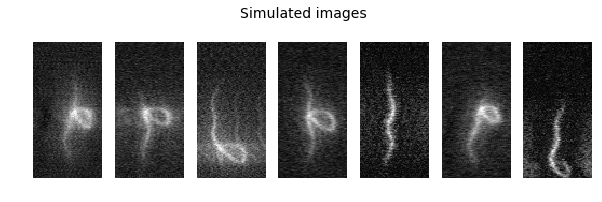

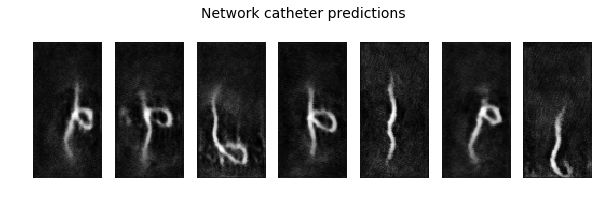

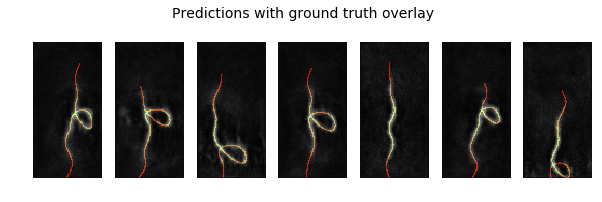

saving best model
0m 6s
Epoch 2/99
----------
LR 0.01
Batch 0 : 0.029395056888461113
Batch 10 : 0.02825120836496353
Batch 20 : 0.026020539924502373
Batch 30 : 0.02520696073770523
Loss train : 0.02698997
Batch 0 : 0.024000510573387146
Loss val : 0.02419398


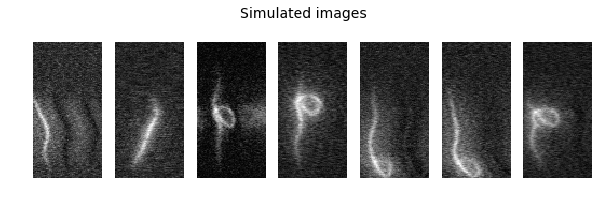

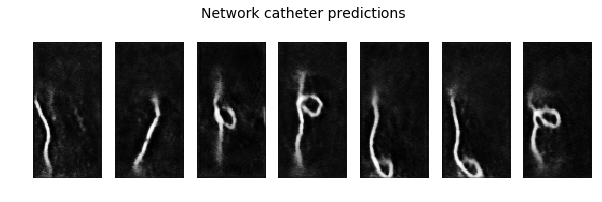

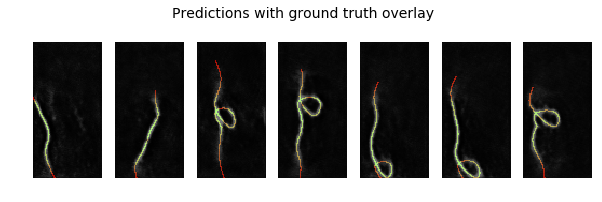

saving best model
0m 6s
Epoch 3/99
----------
LR 0.01
Batch 0 : 0.023969091475009918
Batch 10 : 0.022377600893378258
Batch 20 : 0.02205742336809635
Batch 30 : 0.021206995472311974
Loss train : 0.02226384
Batch 0 : 0.019400421530008316
Loss val : 0.02053866


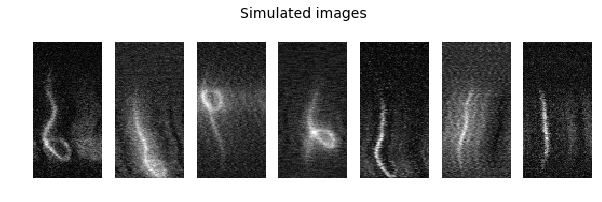

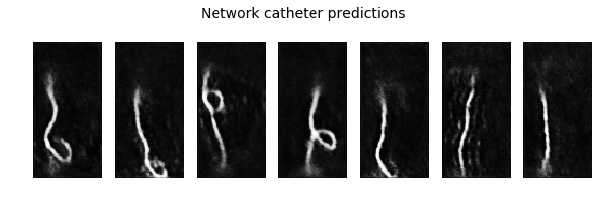

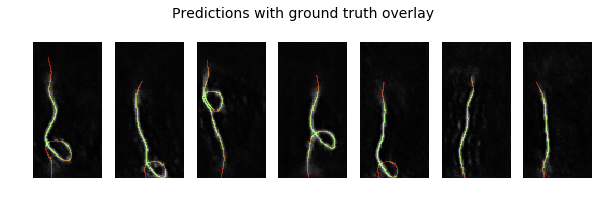

saving best model
0m 6s
Epoch 4/99
----------
LR 0.01
Batch 0 : 0.02145667001605034
Batch 10 : 0.019956238567829132
Batch 20 : 0.018339145928621292
Batch 30 : 0.017469165846705437
Loss train : 0.01938180
Batch 0 : 0.018403250724077225
Loss val : 0.01827312


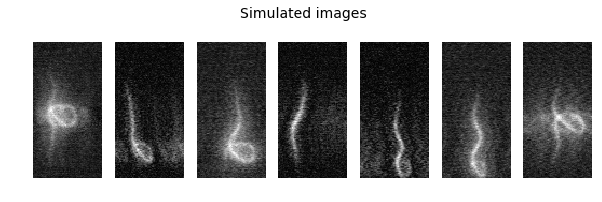

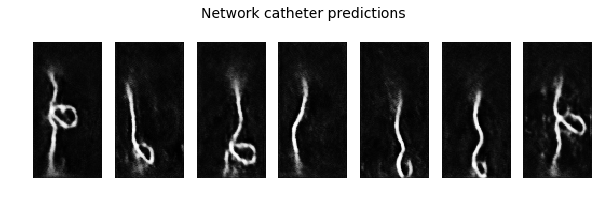

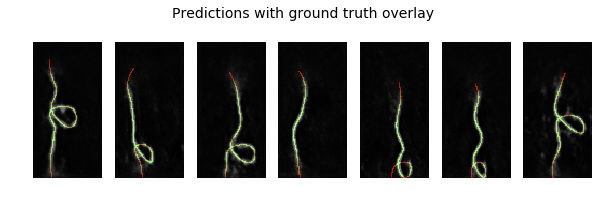

saving best model
0m 6s
Epoch 5/99
----------
LR 0.01
Batch 0 : 0.018101198598742485
Batch 10 : 0.017684726044535637
Batch 20 : 0.015982290729880333
Batch 30 : 0.017721034586429596
Loss train : 0.01748583
Batch 0 : 0.017339037731289864
Loss val : 0.01668298


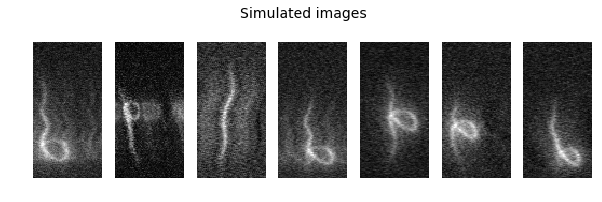

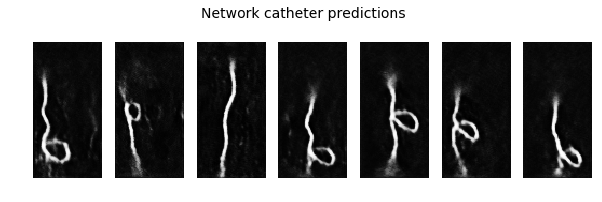

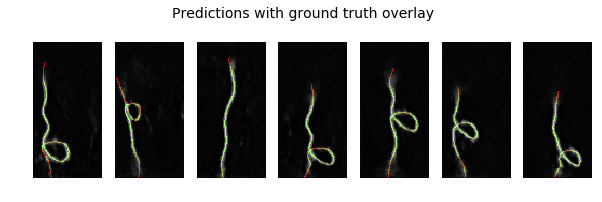

saving best model
0m 7s
Epoch 6/99
----------
LR 0.01
Batch 0 : 0.016956282779574394
Batch 10 : 0.01594879850745201
Batch 20 : 0.016343919560313225
Batch 30 : 0.015450947917997837
Loss train : 0.01610944
Batch 0 : 0.015776269137859344
Loss val : 0.01563541


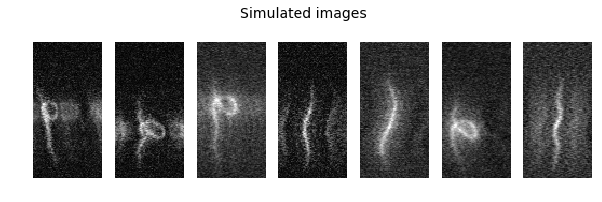

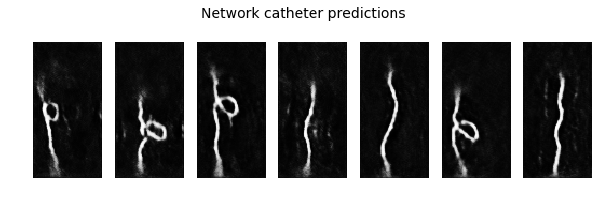

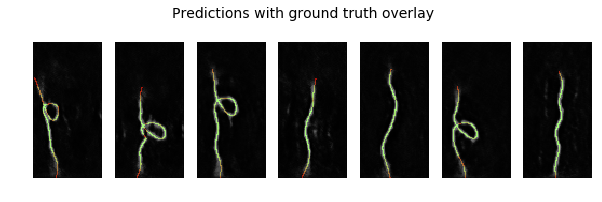

saving best model
0m 6s
Epoch 7/99
----------
LR 0.01
Batch 0 : 0.015726609155535698
Batch 10 : 0.015754248946905136
Batch 20 : 0.014618036337196827
Batch 30 : 0.01494099572300911
Loss train : 0.01505222
Batch 0 : 0.015343823470175266
Loss val : 0.01468069


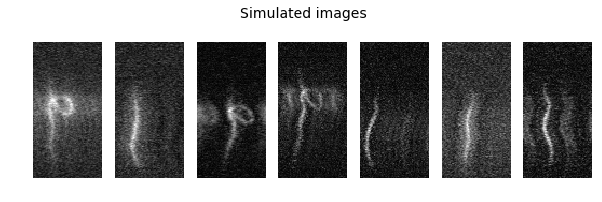

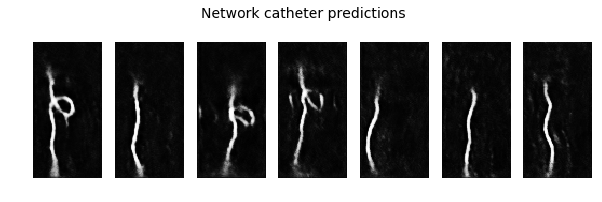

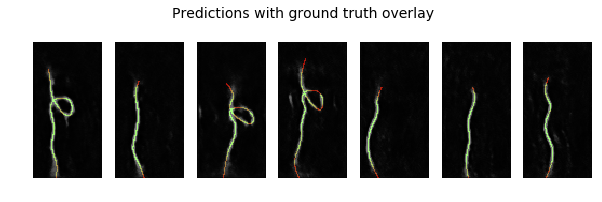

saving best model
0m 7s
Epoch 8/99
----------
LR 0.01
Batch 0 : 0.013571471907198429
Batch 10 : 0.015186609700322151
Batch 20 : 0.014150206930935383
Batch 30 : 0.014498693868517876
Loss train : 0.01422819
Batch 0 : 0.013742818497121334
Loss val : 0.01401334


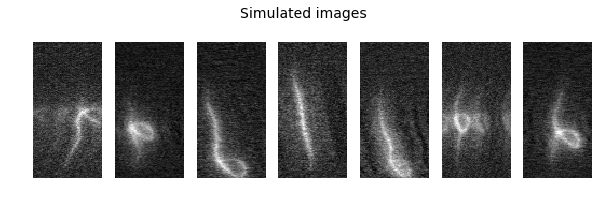

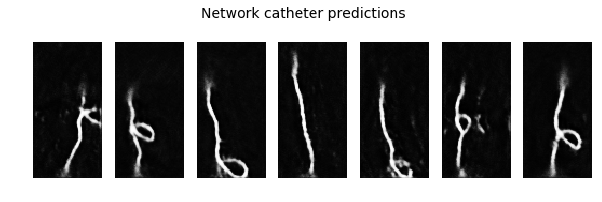

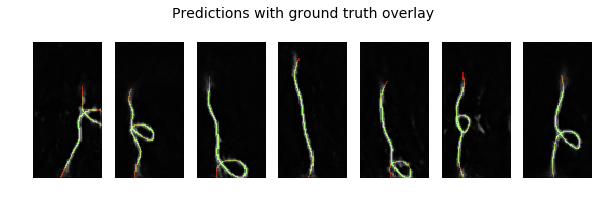

saving best model
0m 7s
Epoch 9/99
----------
LR 0.01
Batch 0 : 0.014242051169276237
Batch 10 : 0.013831362128257751
Batch 20 : 0.013680171221494675
Batch 30 : 0.013766707852482796
Loss train : 0.01356200
Batch 0 : 0.01343925204128027
Loss val : 0.01353555


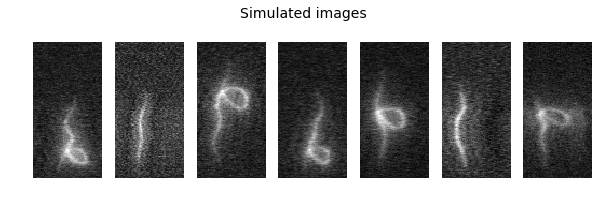

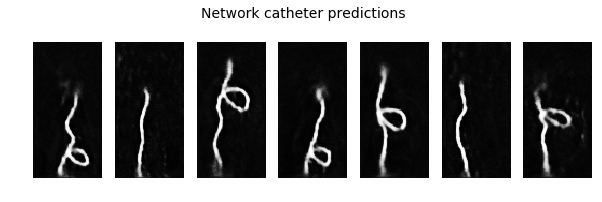

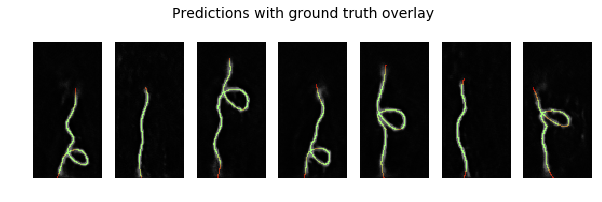

saving best model
0m 7s
Epoch 10/99
----------
LR 0.01
Batch 0 : 0.01390068233013153
Batch 10 : 0.013169344514608383
Batch 20 : 0.013008646667003632
Batch 30 : 0.0125234704464674
Loss train : 0.01300956
Batch 0 : 0.01319192536175251
Loss val : 0.01307543


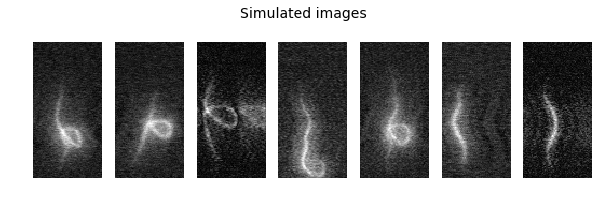

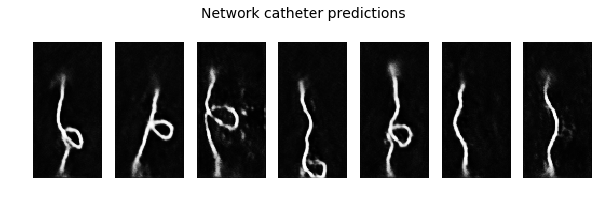

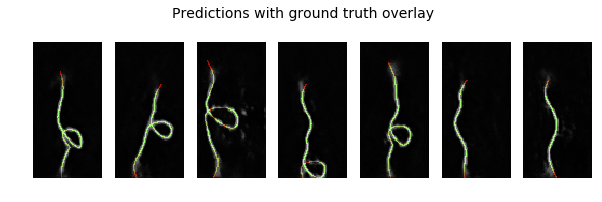

saving best model
0m 6s
Epoch 11/99
----------
LR 0.01
Batch 0 : 0.012053477577865124
Batch 10 : 0.011662399396300316
Batch 20 : 0.012599034234881401
Batch 30 : 0.012818839401006699
Loss train : 0.01254303
Batch 0 : 0.01241996604949236
Loss val : 0.01270234


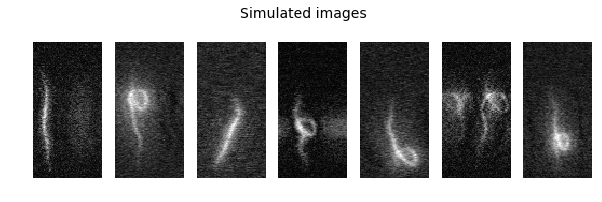

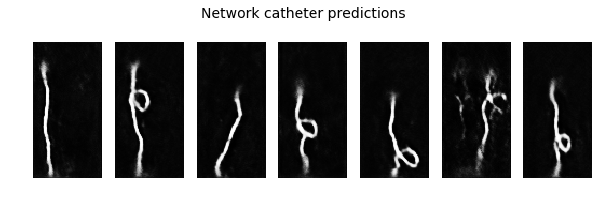

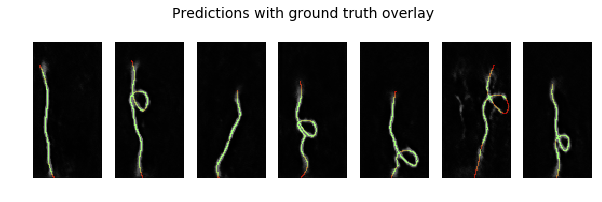

saving best model
0m 7s
Epoch 12/99
----------
LR 0.01
Batch 0 : 0.012213407084345818
Batch 10 : 0.012742647901177406
Batch 20 : 0.012045826762914658
Batch 30 : 0.011235669255256653
Loss train : 0.01213970
Batch 0 : 0.012531310319900513
Loss val : 0.01239855


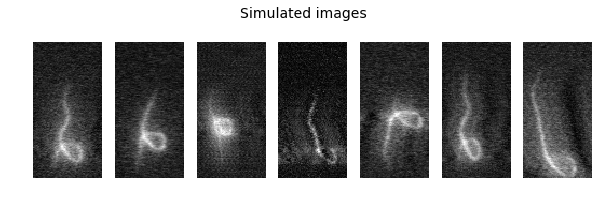

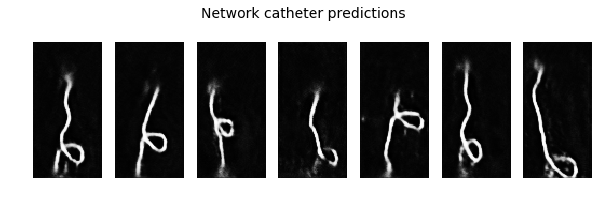

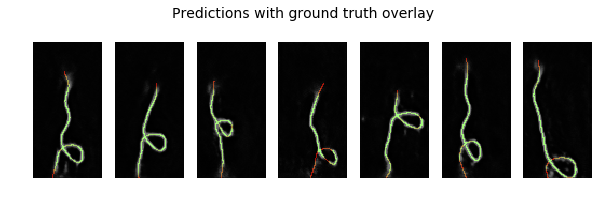

saving best model
0m 7s
Epoch 13/99
----------
LR 0.01
Batch 0 : 0.011148993857204914
Batch 10 : 0.011968161910772324
Batch 20 : 0.011809248477220535
Batch 30 : 0.01092730276286602
Loss train : 0.01176981
Batch 0 : 0.01209168415516615
Loss val : 0.01210828


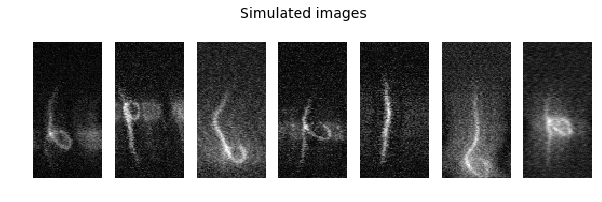

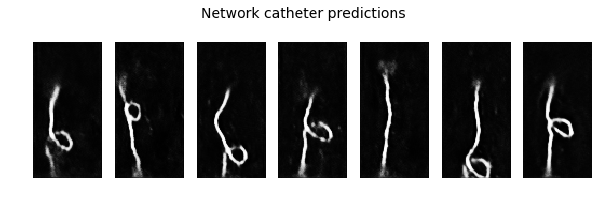

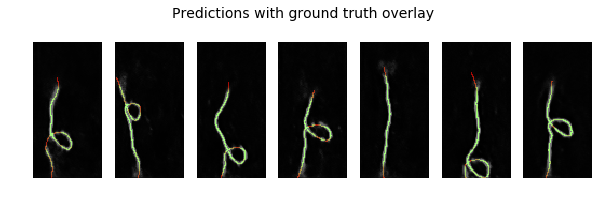

saving best model
0m 6s
Epoch 14/99
----------
LR 0.01
Batch 0 : 0.01151313167065382
Batch 10 : 0.01163430418819189
Batch 20 : 0.010839481838047504
Batch 30 : 0.011531034484505653
Loss train : 0.01146301
Batch 0 : 0.012783749029040337
Loss val : 0.01184418


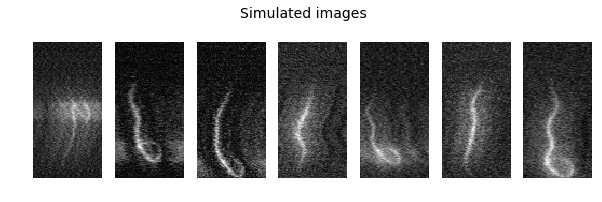

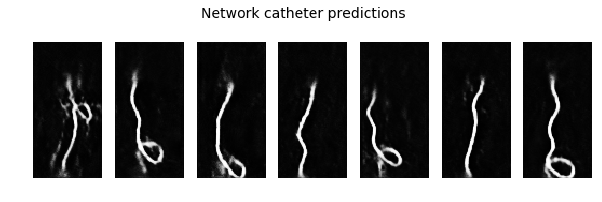

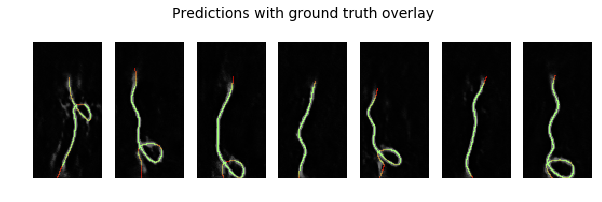

saving best model
0m 6s
Epoch 15/99
----------
LR 0.01
Batch 0 : 0.01170865073800087
Batch 10 : 0.011023289524018764
Batch 20 : 0.011211423203349113
Batch 30 : 0.011628846637904644
Loss train : 0.01110940
Batch 0 : 0.010845310054719448
Loss val : 0.01165071


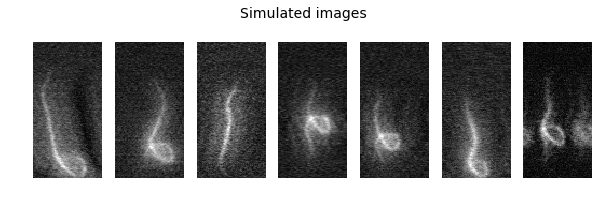

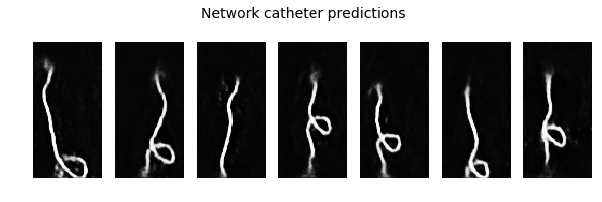

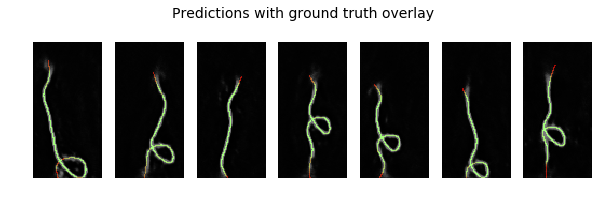

saving best model
0m 6s
Epoch 16/99
----------
LR 0.01
Batch 0 : 0.010600018315017223
Batch 10 : 0.011101441457867622
Batch 20 : 0.010718420147895813
Batch 30 : 0.010962232947349548
Loss train : 0.01087913
Batch 0 : 0.01151738129556179
Loss val : 0.01144799


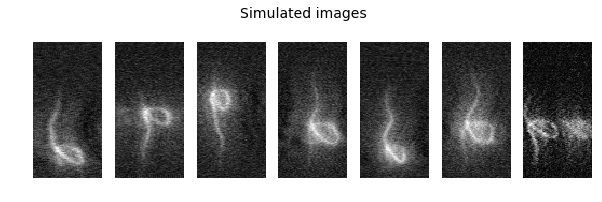

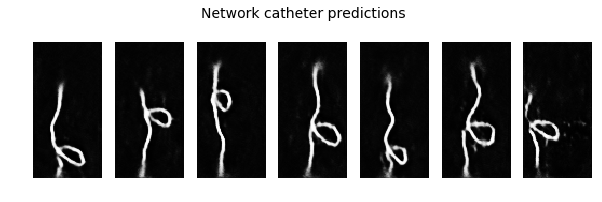

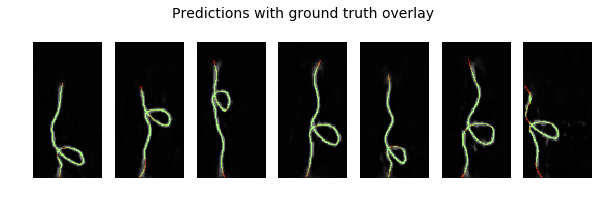

saving best model
0m 6s
Epoch 17/99
----------
LR 0.01
Batch 0 : 0.010979179292917252
Batch 10 : 0.010554761625826359
Batch 20 : 0.010397992096841335
Batch 30 : 0.010333631187677383
Loss train : 0.01062628
Batch 0 : 0.011074380949139595
Loss val : 0.01129261


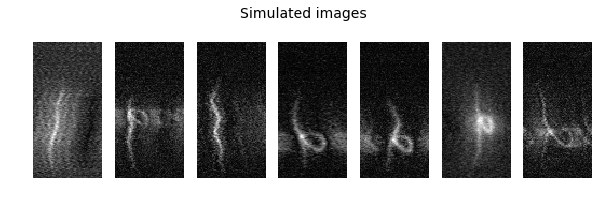

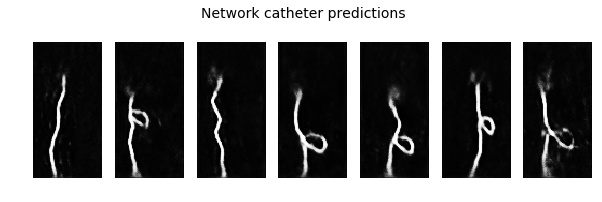

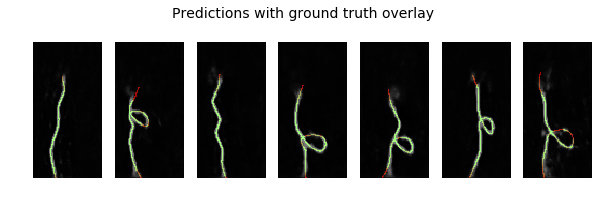

saving best model
0m 6s
Epoch 18/99
----------
LR 0.01
Batch 0 : 0.011261764913797379
Batch 10 : 0.009826060384511948
Batch 20 : 0.01043825875967741
Batch 30 : 0.011013248935341835
Loss train : 0.01036917
Batch 0 : 0.011328154243528843
Loss val : 0.01110463


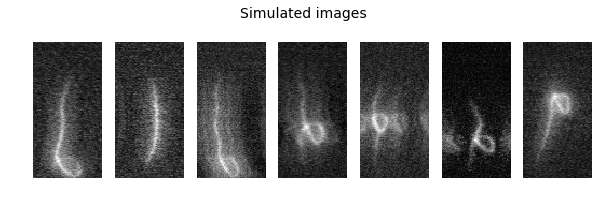

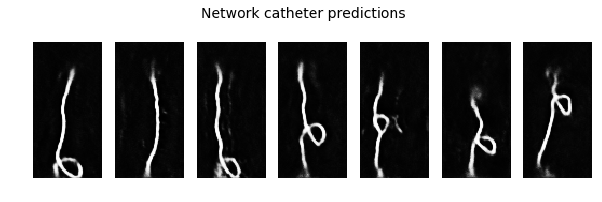

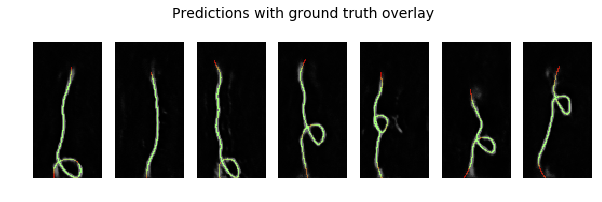

saving best model
0m 6s
Epoch 19/99
----------
LR 0.01
Batch 0 : 0.010491160675883293
Batch 10 : 0.009972736239433289
Batch 20 : 0.010415468364953995
Batch 30 : 0.009897058829665184
Loss train : 0.01014328
Batch 0 : 0.01142689399421215
Loss val : 0.01099224


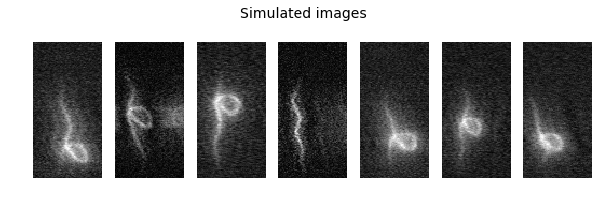

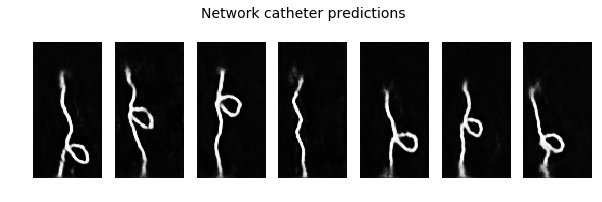

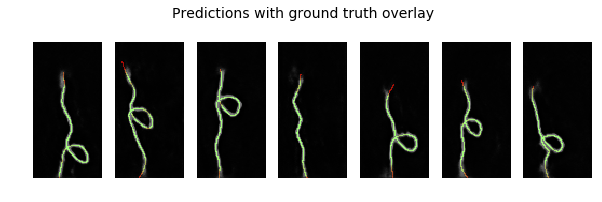

saving best model
0m 6s
Epoch 20/99
----------
LR 0.01
Batch 0 : 0.01040801964700222
Batch 10 : 0.010202714242041111
Batch 20 : 0.00954332947731018
Batch 30 : 0.009717798791825771
Loss train : 0.00994874
Batch 0 : 0.010814223438501358
Loss val : 0.01088689


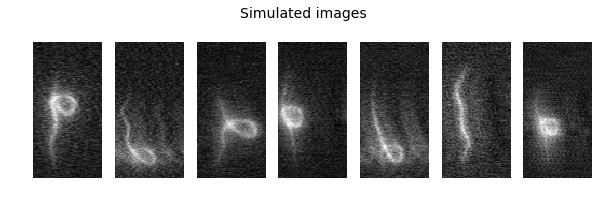

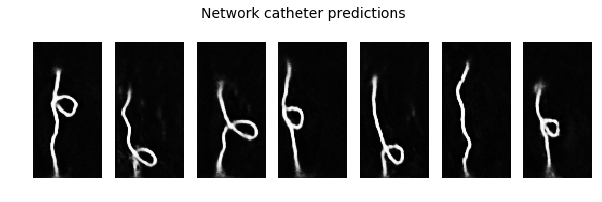

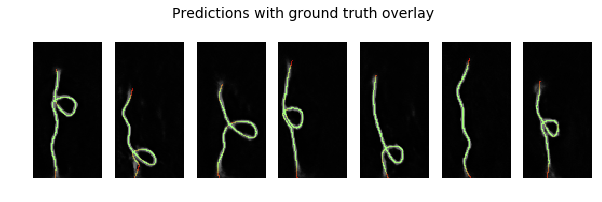

saving best model
0m 6s
Epoch 21/99
----------
LR 0.01
Batch 0 : 0.00995481014251709
Batch 10 : 0.0097694993019104
Batch 20 : 0.008850282989442348
Batch 30 : 0.009762086905539036
Loss train : 0.00973430
Batch 0 : 0.010948439128696918
Loss val : 0.01081173


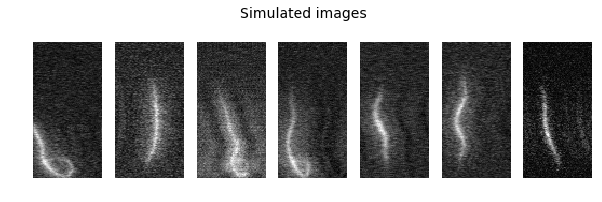

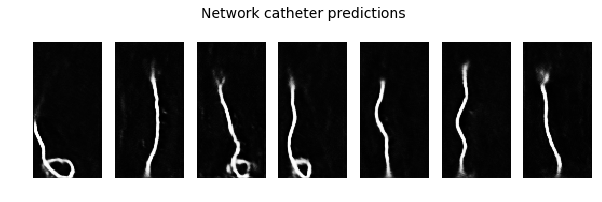

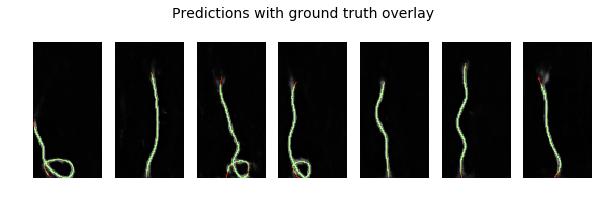

saving best model
0m 6s
Epoch 22/99
----------
LR 0.01
Batch 0 : 0.009267857298254967
Batch 10 : 0.009500280022621155
Batch 20 : 0.00982492696493864
Batch 30 : 0.010350610129535198
Loss train : 0.00952823
Batch 0 : 0.010639225132763386
Loss val : 0.01068004


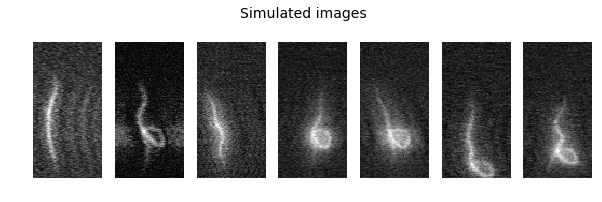

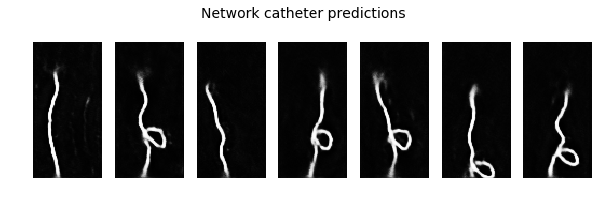

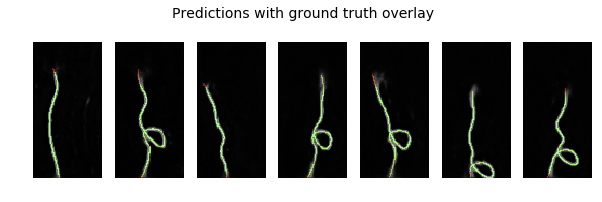

saving best model
0m 6s
Epoch 23/99
----------
LR 0.01
Batch 0 : 0.00929951760917902
Batch 10 : 0.00905703380703926
Batch 20 : 0.009294122457504272
Batch 30 : 0.00947827473282814
Loss train : 0.00934950
Batch 0 : 0.010391240939497948
Loss val : 0.01058133


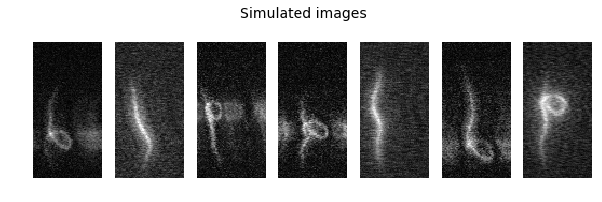

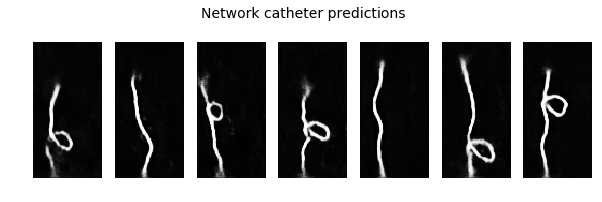

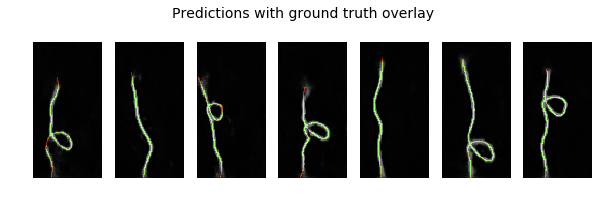

saving best model
0m 7s
Epoch 24/99
----------
LR 0.01
Batch 0 : 0.009241151623427868
Batch 10 : 0.009484128095209599
Batch 20 : 0.00903127621859312
Batch 30 : 0.008799844421446323
Loss train : 0.00917598
Batch 0 : 0.010968935675919056
Loss val : 0.01055750


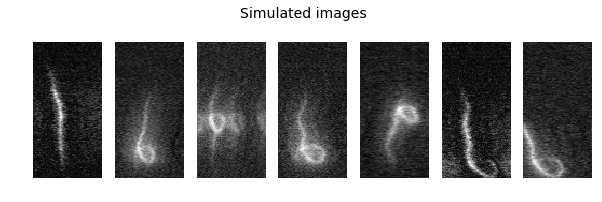

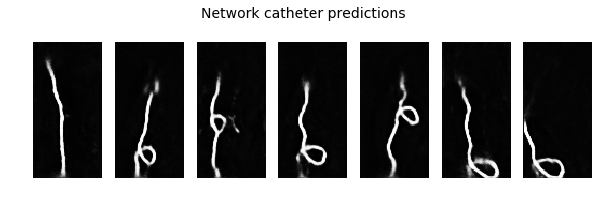

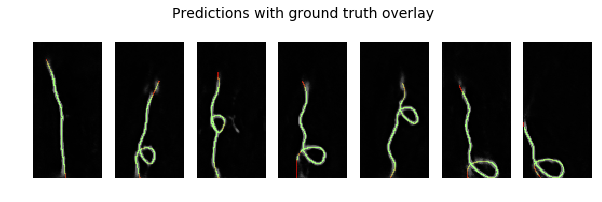

saving best model
0m 6s
Epoch 25/99
----------
LR 0.01
Batch 0 : 0.009877756237983704
Batch 10 : 0.009045783430337906
Batch 20 : 0.008831853047013283
Batch 30 : 0.008105769753456116
Loss train : 0.00898136
Batch 0 : 0.01007407158613205
Loss val : 0.01049090


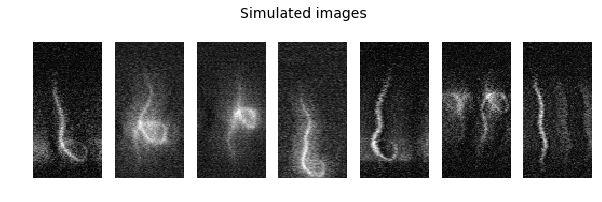

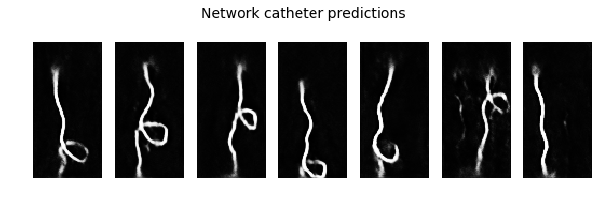

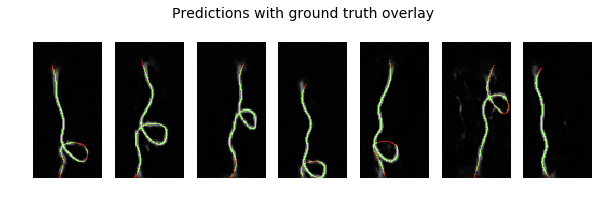

saving best model
0m 6s
Epoch 26/99
----------
LR 0.01
Batch 0 : 0.008601433597505093
Batch 10 : 0.00872791837900877
Batch 20 : 0.008461317978799343
Batch 30 : 0.008648103103041649
Loss train : 0.00884487
Batch 0 : 0.010709638707339764
Loss val : 0.01046355


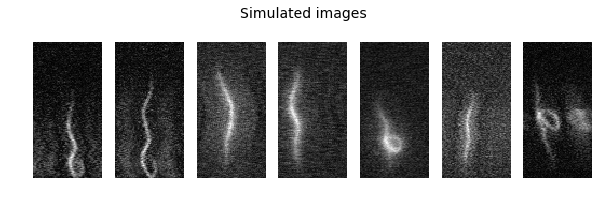

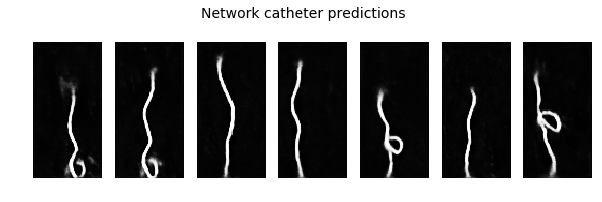

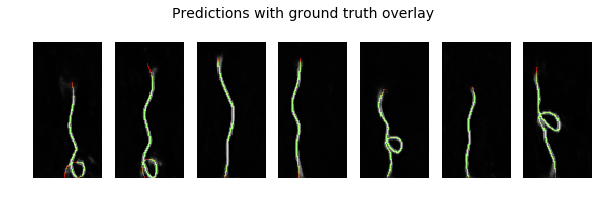

saving best model
0m 6s
Epoch 27/99
----------
LR 0.01
Batch 0 : 0.008535312488675117
Batch 10 : 0.008426239714026451
Batch 20 : 0.008701251819729805
Batch 30 : 0.008728698827326298
Loss train : 0.00866856
Batch 0 : 0.01041429303586483
Loss val : 0.01039821


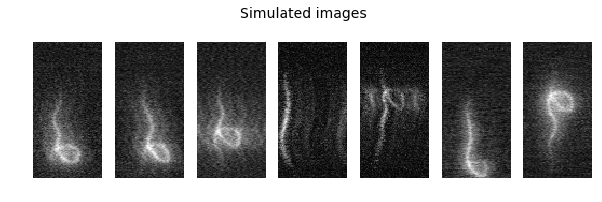

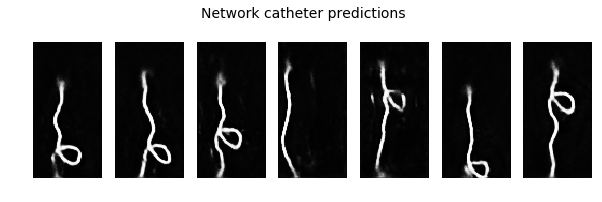

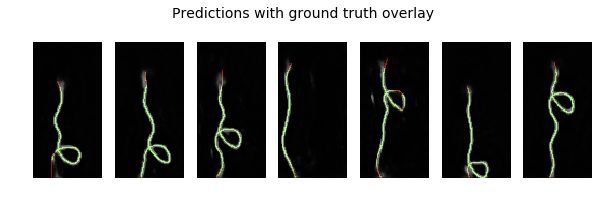

saving best model
0m 7s
Epoch 28/99
----------
LR 0.01
Batch 0 : 0.008895405568182468
Batch 10 : 0.009057068265974522
Batch 20 : 0.008620066568255424
Batch 30 : 0.00807168148458004
Loss train : 0.00853291
Batch 0 : 0.010801724158227444
Loss val : 0.01033620


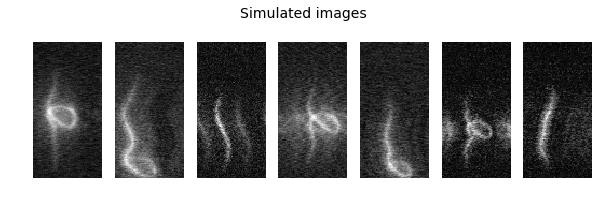

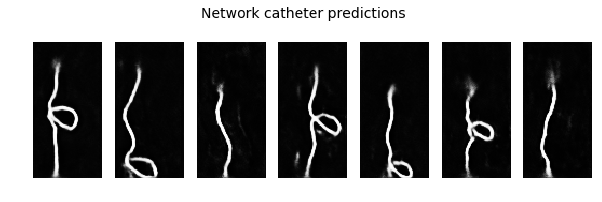

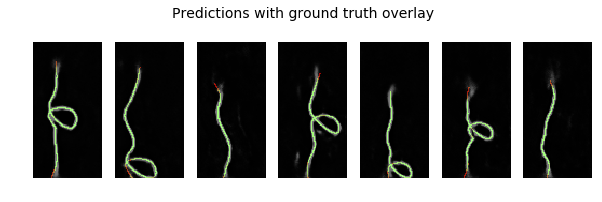

saving best model
0m 7s
Epoch 29/99
----------
LR 0.01
Batch 0 : 0.00849955901503563
Batch 10 : 0.008070483803749084
Batch 20 : 0.008390173316001892
Batch 30 : 0.008162718266248703
Loss train : 0.00829806
Batch 0 : 0.009722722694277763


In [ ]:
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

def train_model(model, optimizer, scheduler = None, num_epochs=25, train_stats_period=10):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() if scheduler is not None else None
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            loss_vec = []

            for batch_id, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels_mod = torch.Tensor(modify_gts(labels))
                labels_mod = labels_mod.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    loss = loss_function(torch.squeeze(outputs), labels_mod.type(torch.float32))
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (loss.item())
                    loss_vec.append(loss.item())  

                    if batch_id % train_stats_period == 0:
                        print('Batch', batch_id, ':', loss.item())

                # statistics
                epoch_samples += inputs.size(0)

            # print loss at every epoch 
            epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)
            #epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)/float(epoch_samples)
            print('Loss ' + phase, ': {:.8f}'.format(epoch_loss))
            writer.add_scalar('Loss ' + phase, epoch_loss, epoch)

            if phase == 'val':
                visualise(inputs.squeeze(1).cpu().numpy(), 'Simulated images')
                preds = outputs.squeeze(1).cpu().numpy()
                visualise(preds, 'Network catheter predictions')
                colour_outputs = outputs.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).cpu().numpy()
                colour_outputs = norm(colour_outputs)
                red_labels = np.zeros(colour_outputs.shape)
                red_labels[:,:,:,0] = labels * (1.3 - preds)
                red_labels[:,:,:,1] = labels * preds
                overlay = colour_outputs + red_labels
                overlay = norm(overlay)
                visualise(overlay, 'Predictions with ground truth overlay')
                
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                torch.save(model.state_dict(), save_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

num_class = 1
model = Unet_pytorch.UNet(num_class).float()
model = model.to(device)

optimizer_ft = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9) 

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

train_model(model, optimizer_ft, num_epochs=100)

## Evaluate on <u>real</u> data

Performance on real data
16
239


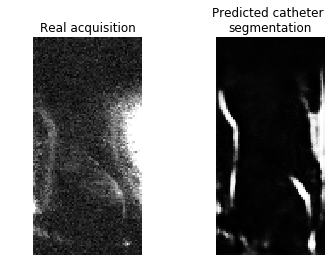

In [125]:
model.load_state_dict(torch.load(save_path))
model = model.to(device)
model.eval()

def infer(model, im):
    im = torch.Tensor(im).unsqueeze(0).unsqueeze(0).to(device)
    return model(im).squeeze(0).squeeze(0).cpu().detach().numpy()

print('Performance on real data')
import imageio
from PIL import Image
gif = imageio.get_reader('cropped_gif.gif')
test_im = np.array(list(gif))[100]
test_im = np.array(Image.fromarray(test_im).resize([64, 128]))
test_im = norm(test_im)
# test_im = norm(np.array(Image.fromarray(test_im).resize([64, 128])))
plt.subplot(121)
show(test_im)
plt.title('Real acquisition')

# test_im = torch.Tensor(ims[0].float()).unsqueeze(0).to(device)
test_pred = infer(model, test_im)
plt.subplot(122)
show(test_pred)
plt.title('Predicted catheter \nsegmentation')
plt.show()

### Testing skeletonisation

Skeletonisation


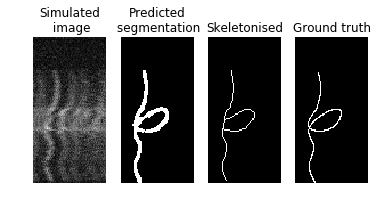

In [60]:
print('Skeletonisation')
test_im = np.squeeze(ims[0]).float()
from skimage.morphology import skeletonize
plt.subplot(141)
show(test_im)
plt.title('Simulated\n image')

plt.subplot(144)
show(np.squeeze(gts_thin[0]))
plt.title('Ground truth')

sim_pred = infer(model, test_im)
plt.subplot(142)
show(sim_pred > 0.5)
plt.title('Predicted\n segmentation')

plt.subplot(143)
show(skeletonize(sim_pred > 0.5))
plt.title('Skeletonised')
plt.show()